In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings, os
import numpy as np
import colors

color_dict = colors.get_colors()

# Set default settings for plotting
warnings.filterwarnings('ignore')
sns.set_style('ticks')
sns.set_context('paper', font_scale=2)
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [2]:
import sys
print('Python version: ' + sys.version)
modules = ['pandas', 'scipy','matplotlib','numpy','seaborn']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

Python version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas 0.25.1
scipy 1.3.1
matplotlib 3.1.1
numpy 1.17.2
seaborn 0.9.0


In [75]:
# This function is used to plot z-scores along the length of the AA in a protein in a scatter plot.
# Missense, silent, and nosense mutations are split up by color. 
# Another axis shows z-scores of controls and guides that don't target the exon of the gene. 
# Last updated 23-Apr-2020
# ZMS

def stem_box_plot(ycol,df,xcol,ylabel,title,linepos,xlims,ylims,xlabel,xticks,yticks,n_position,d1,d2):

    #Set style/parameters for plot
    sns.set_context("paper",font_scale=1)
    sns.set_style('ticks')
    fig,ax = plt.subplots(figsize=(5,2), sharex=True, sharey=True)
    gs = fig.add_gridspec(1, 5)
    ax = plt.subplot(gs[:3])
    ax2 = plt.subplot(gs[3:],sharey=ax)
    boxprops = {'edgecolor': 'black','linewidth':0.5}
    lineprops = {'color': 'black','linewidth':0.5}
    noprops = {'linewidth': 0.000001}
    fig.suptitle(title, fontsize=8)
    sns.despine()
    ax.tick_params(length=2, width=0.5,labelsize=6)
    ax2.tick_params(length=2, width=0.5,labelsize=6)
    for _,s in ax.spines.items():
        s.set_linewidth(0.5)
    for _,s in ax2.spines.items():
        s.set_linewidth(0.5)
    boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,  
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})
    median_kwargs = dict({'boxprops': noprops, 'medianprops': lineprops,
                       'whiskerprops': noprops, 'capprops': noprops,
                       'width': 0.75})
    color_dict['Intergenic control'] = sns.color_palette('Set2')[7]
    color_dict['Non-targeting control'] = sns.color_palette('Set2')[7]
    color_dict['Intron/UTR'] = color_dict['Intron']
    
    # Draw shaded area on scatter plot to span x1 and x2 values
    ax.axvspan(d1[0],d1[1],facecolor=sns.color_palette('Set2')[7],alpha=0.5,edgecolor=None)
    ax.axvspan(d2[0],d2[1],facecolor=sns.color_palette('Set2')[7],alpha=0.2,edgecolor=None)

    
    # Adds a dashed line to plots at y = 'linepos'
    for pos in linepos:
        ax.axhline(pos,color='black',linestyle='dashed',zorder=2,linewidth=0.5)
        ax2.axhline(pos,color='black',linestyle='dashed',zorder=2,linewidth=0.5)

    #Make stem plot
    mut_types=['Silent','Missense','Nonsense']
    count = 0
    for mut_type in mut_types: 
        data = df[(df['Mutation bin'] == mut_type) & (df['Gene Symbol'] == title)].dropna(subset=[xcol])
        count = count + len(data)
        ax.scatter(data[xcol],data[ycol],c=[color_dict[mut_type]],label = mut_type, s=15,zorder=3,alpha=1,linewidths=0.01)
    #Stem plot formating
    ax.set_xlabel('Amino acid residue',fontsize=8,color='black')
    ax.set_ylabel(ylabel,fontsize=8,color='black')
    ax.text(n_position, ylims[0]+0.5, 'n: ' + str(count),fontsize=6,color='black')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    #Plot guides not along exon, exlcuding controls
    small = df.loc[(df['Gene Symbol'] == title) & df['Mutation bin'].str.contains('site|Intron|UTR|edit'),['Mutation bin',ycol]]
    small.loc[small['Mutation bin'] == 'UTR','Mutation bin'] = 'Intron/UTR'
    small.loc[small['Mutation bin'] == 'Intron','Mutation bin'] = 'Intron/UTR'
    small.sort_values(by=['Mutation bin'],inplace=True)
    controls = df.loc[df['Gene Symbol'].str.contains('control',na=False),['Gene Symbol',ycol]]
    controls.rename(columns={"Gene Symbol": 'Mutation bin'},inplace=True)
    controls.sort_values(by=['Mutation bin'],inplace=True)
    small = pd.concat([small,controls])
    categories = small['Mutation bin'].unique().tolist()
    strip = pd.DataFrame(columns=['Mutation bin',ycol])
    outliers = pd.DataFrame(columns=['Mutation bin',ycol])
    bar = pd.DataFrame(columns=['Mutation bin',ycol])
    
    for cat in categories:
        #For sample sizes larger than 20, add to swarm df and then set equal to 0
        strip = strip.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        bar = bar.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        outliers = outliers.append(small.loc[small['Mutation bin'].str.contains(cat)],sort=False, ignore_index=True)
        if len(small.loc[small['Mutation bin'].str.contains(cat)].index) >20 :
            strip.loc[strip['Mutation bin'].str.contains(cat),ycol] = np.nan
            [q1,q3] = outliers.loc[outliers['Mutation bin'].str.contains(cat),ycol].quantile([0.25,0.75])
            IQR = q3-q1
            w1 = q1-1.5*IQR
            w3 = q3+1.5*IQR
            outliers.loc[outliers['Mutation bin'].str.contains(cat) & (outliers[ycol] > w1) & (outliers[ycol] < w3), ycol] = np.nan
        #For data sets <=20, add to swarm dataset & bar data set & then set bar data to NaN
        else: 
            bar.loc[bar['Mutation bin'].str.contains(cat),ycol] = np.nan 

    sns.boxplot(x='Mutation bin',y=ycol,data=bar,palette=color_dict,ax=ax2,
               showfliers=False,**boxplot_kwargs)
    sns.boxplot(x='Mutation bin',y=ycol,data=strip,color='white',ax=ax2,
               showfliers=False,**median_kwargs,showbox=False,showcaps=False,
               whis=0)
    sns.stripplot(x='Mutation bin',y=ycol,data=outliers,palette=color_dict,ax=ax2,s=3.5)

    #Box plot formatting (Axis 2)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.set_xticklabels(['Intron/\nUTR','No\nEdits','Splice\nsite','Intergenic\ncontrol',
                        'Non-\ntargeting\ncontrol'],fontsize=6)
    
    
    # Calculate number of obs per group for position labels
    nobs = []
    for cat in categories:
        nobs.append(len(bar.loc[bar['Mutation bin'] == cat].index))
    nobs_sum = sum(nobs)
    nobs = [str(integer) for integer in nobs]
    nobs = ["n: " + i for i in nobs]

    #Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax2.get_xticklabels()):
        ax2.text(pos[tick], ylims[0]+0.5, nobs[tick],
               horizontalalignment='center', size='x-small', color='black',fontsize=6) 

     
    plt.tight_layout()
    plt.show()
    pan_lethal = len(df.loc[df['Gene Symbol'].str.contains('splice',na=False)]) 
    print('Stem plot: ' + str(count))
    print('Box plot: ' + str(len(small)))
    print('Pan lethal: ' + str(pan_lethal))
    print('Unaccounted for: ' + str(len(df)-count-len(small)-pan_lethal))

    return fig,ax

# BRCA1

In [3]:
brca1 = pd.read_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA1_v1.csv')

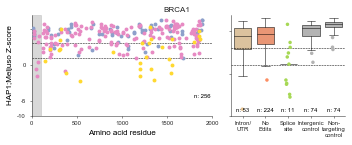

Stem plot: 256
Box plot: 436
Pan lethal: 31
Unaccounted for: 0


In [41]:
col = 'AvgHAP1_MELJUSO;LFC_pdna;z-score'
fig,ax = stem_box_plot(
    ycol=col,
    df=brca1,
    xcol='Median Residues',
    ylabel='HAP1;Meljuso Z-score',
    title='BRCA1',
    linepos=[-2,-4],
    xlims=[0,2000],
    ylims=[-10,2],
    xlabel='Amino acid residue',
    xticks=[0,500,1000,1500,2000],
    yticks=[-10,-5,0],
    n_position = 1800,
    x1 = 1, x2 = 109)
#fig.savefig('../Figures/Fig2_BRCA/Panels/BRCA1_protein_plot_v7.pdf',bbox_inches='tight',dpi=1000)

# BRCA2

In [54]:
brca2 = pd.read_csv('../../Data/Filtered_LFC_files/Table_S2_filtered_BRCA2_v1.csv')

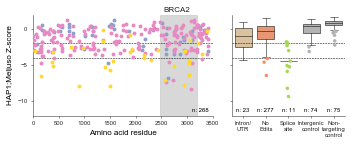

Stem plot: 268
Box plot: 460
Pan lethal: 31
Unaccounted for: 0


In [56]:
col = 'AvgHAP1_MELJUSO;LFC_pdna;z-score'
fig,ax = stem_box_plot(
    ycol=col,
    df=brca2,
    xcol='Median Residues',
    ylabel='HAP1;Meljuso Z-score',
    title='BRCA2',
    linepos=[-4,-2],
    xlims=[0,3500],
    ylims=[-12,2],
    xlabel='Amino acid residue',
    xticks=[0,500,1000,1500,2000,2500,3000,3500],
    yticks=[-10, -5, 0],
    n_position = 3100,
    x1 = 2481, x2 = 3186)
#fig.savefig('../Figures/Fig2_BRCA/Panels/BRCA2_protein_plot_v7.pdf',bbox_inches='tight',dpi=1000)

# PARP1

In [3]:
parp1 = pd.read_csv('../../Data/Filtered_LFC_files/Table_S6_filtered_PARP1_v1.csv')

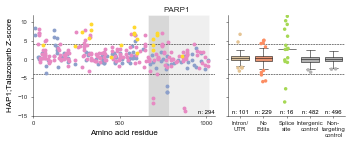

Stem plot: 294
Box plot: 1324
Pan lethal: 0
Unaccounted for: 9533


In [76]:
col = 'HAP1;Talazoparib;AvgAB;LFC_dropout;z-score'
fig,ax = stem_box_plot(
    ycol=col,
    df=parp1,
    xcol='Median Residues',
    ylabel='HAP1;Talazoparib Z-score',
    title='PARP1',
    linepos=[-4,4],
    xlims=[0,1050],
    ylims=[-15,12],
    xlabel='Amino acid residue',
    xticks=[0,500,1000],
    yticks=[-15,-10, -5, 0,5,10],
    n_position = 950,
    d1 = [662,785],
    d2 = [785,1014])
#fig.savefig('../../Figures/Fig5_PARP/PARP1_protein_plot_v1.pdf',bbox_inches='tight',dpi=1000)